# Seminar 1. EEG analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1H81W_DpkHv-ZC9bEbOBW9zfcOe7SCDnR?usp=sharing)

**Plan**

1. Read and visualize the data
2. Preprocess the data
3. Use ICA for noise reduction
4. Compute ERP and plot topomaps for ERP
5. Compute beta band envelopes for ERP
6. Compute coherence

## Part 1

All preprocessing and some data analysis of EEG data can be done using the [Python library MNE](https://mne.tools/stable/auto_tutorials/index.html).

In [1]:
# For Colab only
# !pip install mne
# !pip install mne-connectivity

In [3]:
import warnings
warnings.filterwarnings('ignore')
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mne_connectivity

In [4]:
# not in colab
# %matplotlib notebook
# in colab
%matplotlib inline

mne.io includes the funtions for different EEG-record formats:
https://mne.tools/stable/documentation/implementation.html#supported-data-formats

We will work with data for one patient from [EEG Motor Movement/Imagery Dataset](https://www.physionet.org/content/eegmmidb/1.0.0/).

In [4]:
# !wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf"

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [5]:
# !wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf.event"

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [6]:
# !ls

In [5]:
sample = mne.io.read_raw_edf('S005R03.edf', verbose=False, preload=True)

Get some info about a record

In [6]:
sample.info

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,0.00 Hz
Lowpass,80.00 Hz


In [7]:
# Sampling frequency
sample.info['sfreq']

160.0

In [8]:
# Length in seconds
len(sample) / sample.info['sfreq']

123.0

In [9]:
# Number of channels
len(sample.ch_names)

64

### Channel selection and adding a montage

In [10]:
sample.ch_names[:3]

['Fc5.', 'Fc3.', 'Fc1.']

In [11]:
# fix trailing dots in channel names
# use sample.rename_channels(map)

# YOUR CODE HERE
map = {}
for ch in sample.ch_names:
    map[ch] = ch.replace(".", "")
sample.rename_channels(map)

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,0.00 Hz
Lowpass,80.00 Hz


In [12]:
sample.ch_names[:3]

['Fc5', 'Fc3', 'Fc1']

In [13]:
# 19 channels from International 10-20 system. no A1 and A2 here
# Be careful. Pure 10-20 labeling differs from high-resolution montages
# In MNE, 10-20 montage is actually an extended high-resulution version of 10-20
# FYI, mapping from pure 10-20 to high-resolution versions
# T3 = T7
# T4 = T8
# T5 = P7
# T6 = P8

channels_to_use = [
    # prefrontal
    'Fp1',
    'Fp2',
    # frontal
    'F7',
    'F3',
    'F4',
    'Fz',
    'F8',
    # central and temporal
    'T7',
    'C3',
    'Cz',
    'C4',
    'T8',
    # parietal
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    # occipital
    'O1',
    'O2',
]

In [14]:
sample_1020 = sample.copy().pick(channels_to_use)

# check that everything is OK
assert len(channels_to_use) == len(sample_1020.ch_names)

In [15]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
len(ten_twenty_montage.ch_names)

94

In [16]:
sample.set_montage(ten_twenty_montage)

ValueError: DigMontage is only a subset of info. There are 28 channel positions not present in the DigMontage. The channels missing from the montage are:

['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'Ft7', 'Ft8', 'Tp7', 'Tp8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

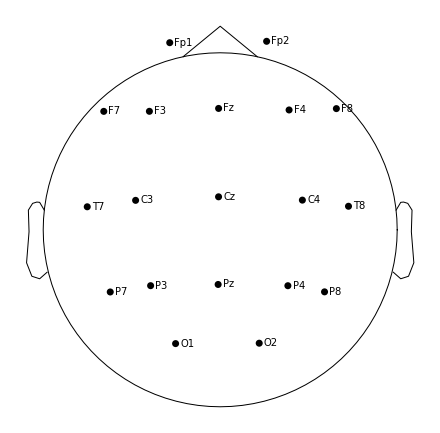

In [19]:
sample_1020.plot_sensors(show_names=True);

### Explore the signals

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_2220/2993928519.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  sample_1020.compute_psd().plot();
C:\Users\Alexander\anaconda3\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


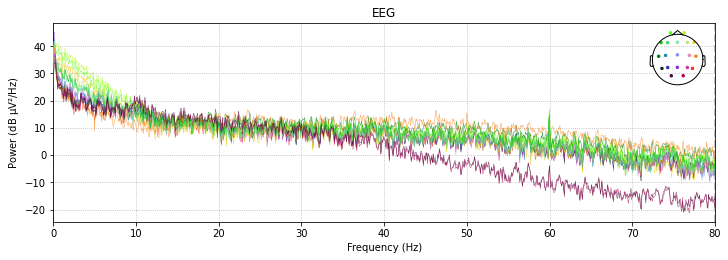

In [20]:
sample_1020.compute_psd().plot();

Do you see peaks connected to power line noise?

The [notch filter's](https://mne.tools/stable/generated/mne.filter.notch_filter.html#mne-filter-notch-filter) purpose is to filter out activity at a specific frequency (rather than a frequency range). Because the alternating current in standard electric outlets in North America oscillates at 60 Hz, electric fields produced by the 60-Hz activity in the environment that surrounds us in our indoor environments frequently contaminates the EEG. Sixty-hertz notch filters (filters designed specifically to filter out 60-Hz activity) are used to attenuate or eliminate this unwanted signal. In countries where line frequencies are 50 Hz, 50-Hz notch filters are used for the same purpose.

#### Band-pass filtering

It's better to remove low-freq components < 1 Hz and high-freq > 50Hz (non-informative for EEG)

Let's use IIR filter.

In [21]:
sample_1020.filter(l_freq=1, h_freq=50, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB



Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


In [22]:
# Plot psd after filtering

# YOUR CODE HERE

#### Plot EEG signals

Using matplotlib as 2D backend.


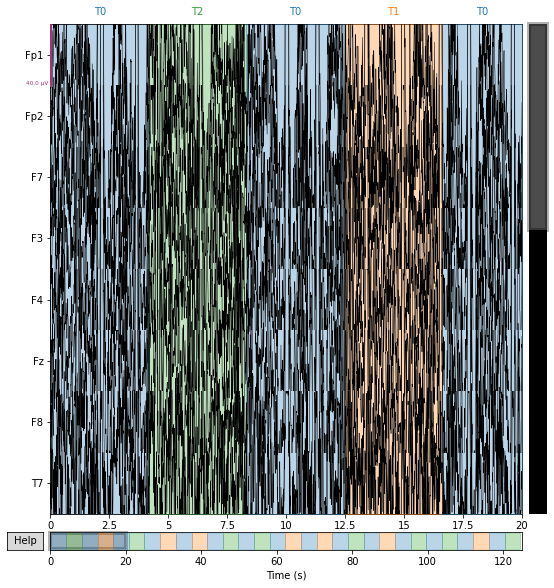

In [23]:
sample_1020.plot(n_channels=8, duration=20);

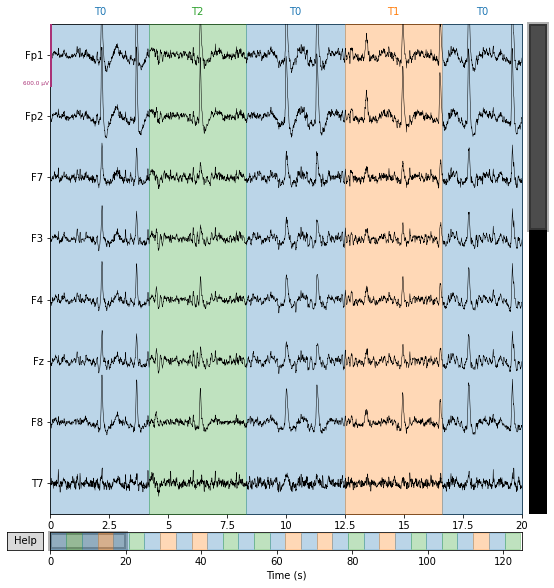

In [24]:
# Plot in better scale. Use 'scalings' argument

# YOUR CODE HERE
sample_1020.plot(n_channels=8, duration=20, scalings=3e-4);

### Extracting events

Mne has several functions for event selection.

* `mne.find_events` is used when events are stored in trigger channels (e.g. FIFF format)
* `mne.events_from_annotations` is used for when events are stored in annotations (EDF+ format)
    
Look for documentation for your EEG-record format

Here we have EDF+ format

In [25]:
events, events_dict = mne.events_from_annotations(sample_1020)

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [26]:
events_dict

{'T0': 1, 'T1': 2, 'T2': 3}

In [27]:
events[:5]

array([[   0,    0,    1],
       [ 672,    0,    3],
       [1328,    0,    1],
       [2000,    0,    2],
       [2656,    0,    1]])

**Epochs** objects are a data structure for representing and analyzing equal-duration chunks of the EEG/MEG signal. Epochs are most often used to represent data that is time-locked to repeated experimental events. The Raw object and the events array are the bare minimum needed to create an Epochs object, which we create with the `mne.Epochs` class constructor.

However, you will almost surely want to change some of the other default parameters. Here we’ll change `tmin` and `tmax` (the time relative to each event at which to start and end each epoch).

In [28]:
epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, preload=True)

Not setting metadata
30 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 209 original time points ...
1 bad epochs dropped


In [29]:
pd.DataFrame(epochs.events, columns=['_', '__', 'event_id'])['event_id'].value_counts()

event_id
1    14
3     8
2     7
Name: count, dtype: int64

Check that length is right

In [30]:
for epoch in epochs:
    break
epoch.shape

(19, 209)

In [31]:
epoch.shape[1] / sample_1020.info['sfreq']

1.30625

In [32]:
sample_1020.to_data_frame().shape

(20000, 20)

In [33]:
df = epochs.to_data_frame()
df.head(3).iloc[:, :10]

,time,condition,epoch,Fp1,Fp2,F7,F3,F4,Fz,F8
0,-0.50000,3,1,236.675891,244.275703,125.936913,88.829681,112.445086,73.438632,145.805904
1,-0.49375,3,1,175.970007,183.425016,103.803572,63.009365,82.687750,48.730906,115.749079
2,-0.48750,3,1,127.095181,132.985975,61.669835,31.478465,62.299189,33.384794,93.870855


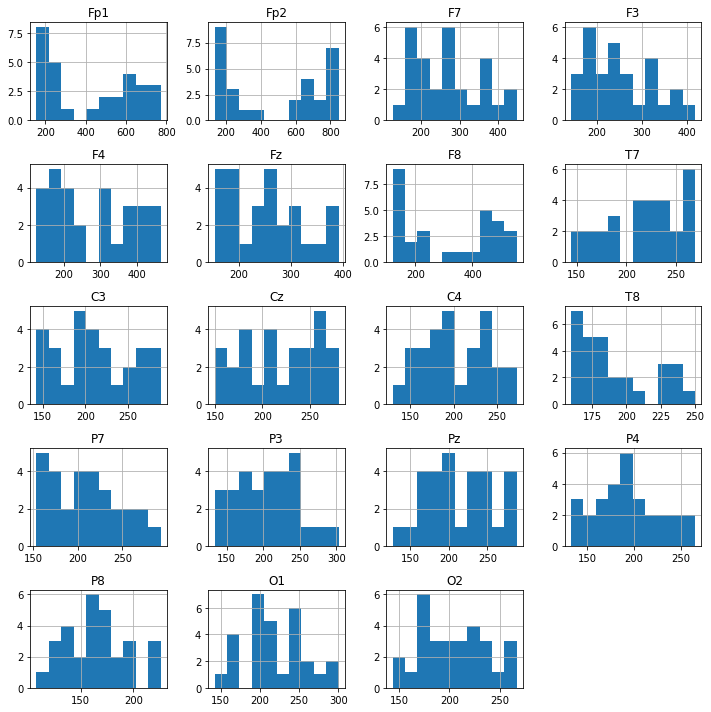

In [34]:
df[sample_1020.ch_names + ['epoch']].groupby('epoch').agg(lambda arr: arr.max() - arr.min()).hist(figsize=[10, 10]);
plt.tight_layout()

Note also that the Epochs constructor accepts parameters `reject` for rejecting individual epochs based on signal amplitude.

In [35]:
epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))

Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 209 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
15 bad epochs dropped


PSD on epochs differs from the raw. More averaging is used

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_2220/2204970765.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd();
C:\Users\Alexander\anaconda3\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


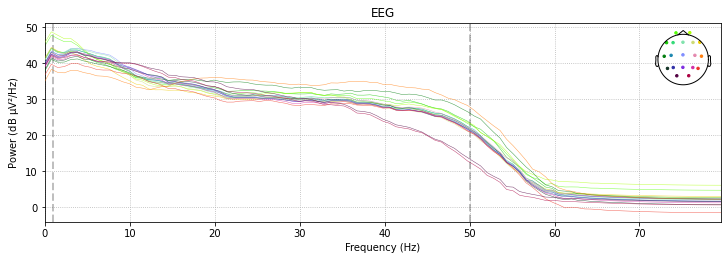

In [36]:
epochs.plot_psd();

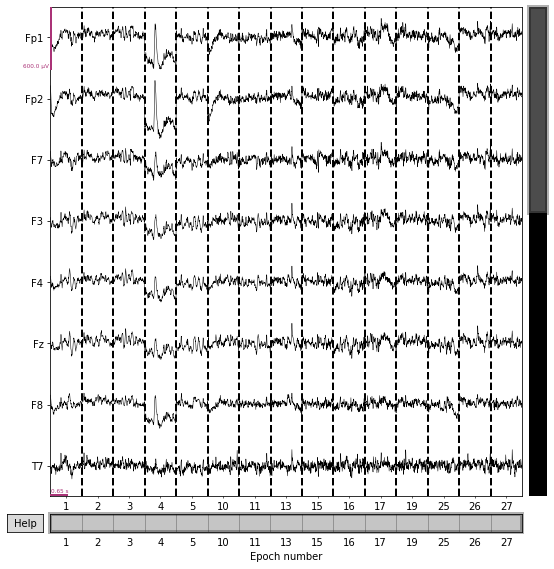

In [37]:
epochs.plot(n_channels=8, scalings={'eeg':3e-4});

In [38]:
epochs.event_id

{'1': 1, '2': 2, '3': 3}

In [39]:
# check number of events of each type
# use epochs.events

# Your code here


In [40]:
evoked_T0 = epochs['1'].average()
evoked_T1 = epochs['2'].average()
evoked_T2 = epochs['3'].average()

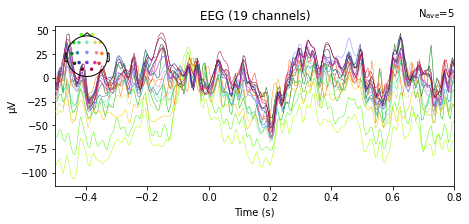

In [41]:
evoked_T0.plot(spatial_colors=True);

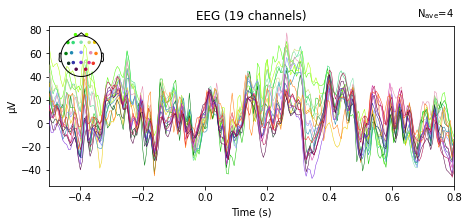

In [42]:
evoked_T1.plot(spatial_colors=True);

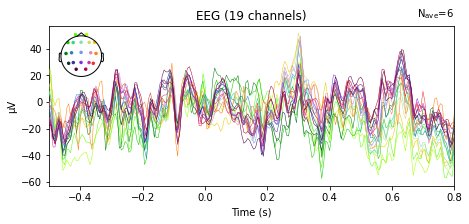

In [43]:
evoked_T2.plot(spatial_colors=True);

## Part 2


### Independent Component Analysis for Artifact Removal

Independent component analysis (ICA) is used to estimate sources given noisy measurements. Imagine 3 instruments playing simultaneously and 3 microphones recording the mixed signals. ICA is used to recover the sources ie. what is played by each instrument.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_ica_blind_source_separation_001.png)

ICA can be used for artifact repair in EEG data. We denote an “artifact” as any component of the EEG signal that is not directly produced by human brain activity.

#### Types of EEG artifacts
The ability to recognize artifacts is the first step in removing them. EEG artifacts can be classified depending on their origin, which can be physiological or external to the human body (non-physiological). The most usual are:

Physiological artifacts:
- Ocular activity
- Muscle activity
- Cardiac activity
- Perspiration
- Respiration

Non-physiological / Technical artifacts:
- Electrode pop
- Cable movement
- Incorrect reference placement
- AC electrical and electromagnetic interferences
- Body movements

More information can be found via links:
- [Types of artefacts](https://www.learningeeg.com/artifacts)
- [How to detect them using ICA](https://www.bitbrain.com/blog/eeg-artifacts)

In [44]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42)

In [45]:
ica.fit(sample_1020)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,17 iterations on raw data (20000 samples)
ICA components,10
Available PCA components,19
Channel types,eeg
ICA components marked for exclusion,—


Using `get_explained_variance_ratio()`, we can retrieve the fraction of variance in the original data that is explained by our ICA components in the form of a dictionary:

In [46]:
explained_var_ratio = ica.get_explained_variance_ratio(sample_1020)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fraction of eeg variance explained by all components: 0.9738186007059333


Creating RawArray with float64 data, n_channels=10, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


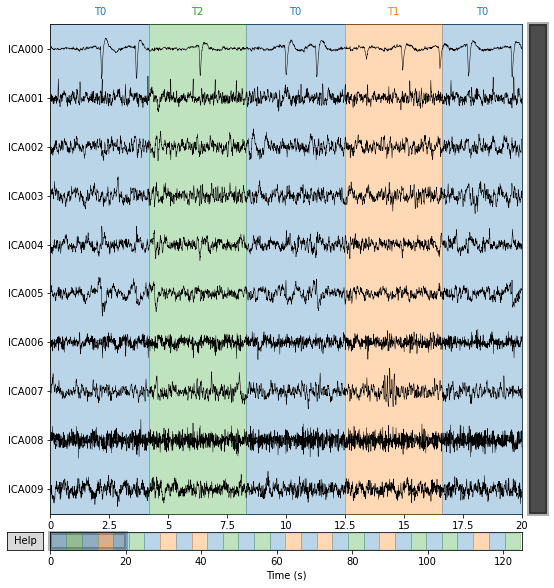

In [47]:
ica.plot_sources(sample_1020);

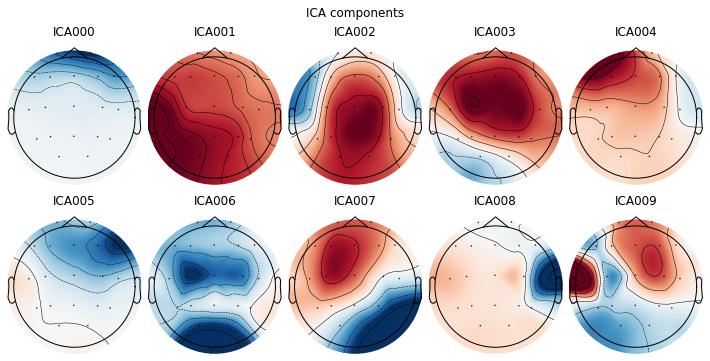

In [48]:
ica.plot_components();

Inspect ICA components more deeply. Check out spectrogram. Segments info is not very relevant here since we build ICA on the raw data

We expect to see alpha and beta rythms picks on the spectrogram for good components (7-13 Hz and 13-30Hz respectively). And also slight decrease as frequency goes higher

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


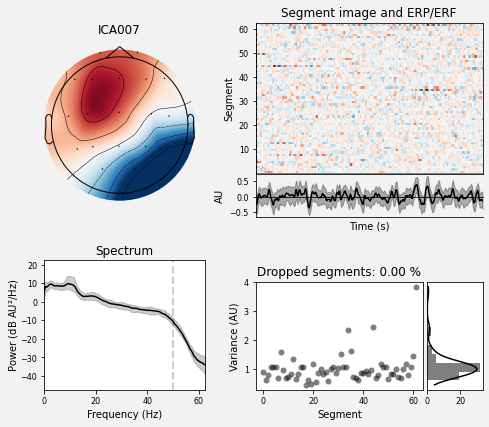

In [49]:
ica.plot_properties(sample_1020, picks=[7]);

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components


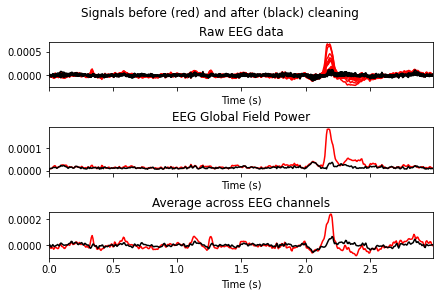

In [50]:
# blinks
ica.plot_overlay(sample_1020, exclude=[0,1,2]);

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components


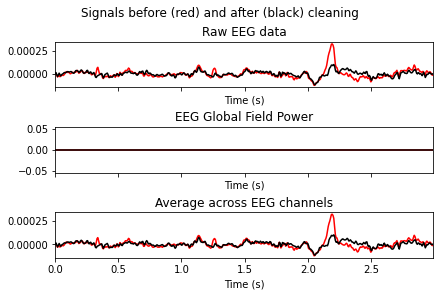

In [51]:
ica.plot_overlay(sample_1020, exclude=[0, 1], picks=['F3']);

In [52]:
ica.exclude = [0,1]

In [53]:
sample_1020_clr = sample_1020.copy()

In [54]:
ica.apply(sample_1020_clr)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components


Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


In [55]:
# plot channels

# YOUR CODE HERE

In [56]:
epochs = mne.Epochs(sample_1020_clr, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))


Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 209 original time points ...
1 bad epochs dropped


In [57]:
evoked_T0 = epochs['1'].average()
evoked_T1 = epochs['2'].average()
evoked_T2 = epochs['3'].average()

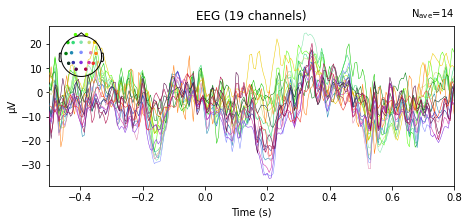

In [58]:
evoked_T0.plot(spatial_colors=True);

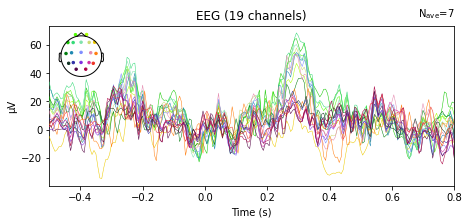

In [59]:
evoked_T1.plot(spatial_colors=True);

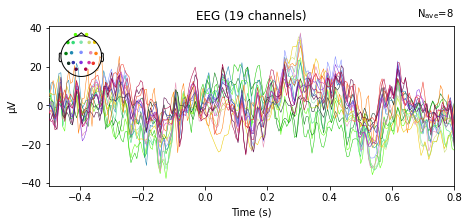

In [60]:
evoked_T2.plot(spatial_colors=True);

Let's plot Global Field Power (GFP).

GFP is, generally speaking, a measure of agreement of the signals picked up by all sensors across the entire scalp: if all sensors have the same value at a given time point, the GFP will be zero at that time point. If the signals differ, the GFP will be non-zero at that time point. GFP peaks may reflect “interesting” brain activity, warranting further investigation.

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


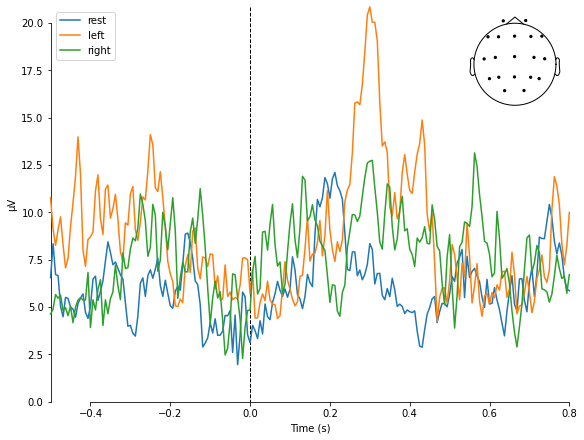

In [61]:
mne.viz.plot_compare_evokeds(
    dict(rest=evoked_T0, left=evoked_T1, right=evoked_T2),
    legend="upper left",
    show_sensors="upper right",
);

We can also get a more detailed view of each Evoked object using other plotting methods such as `plot_joint` or `plot_topomap`. For both plots we can set time points. However, if we choose `times = 'peaks'`, time points will be chosen automatically by checking for 3 local maxima in Global Field Power (GFP).


No projector specified for this dataset. Please consider the method self.add_proj.


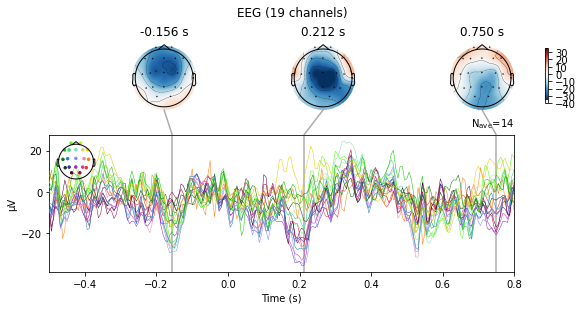

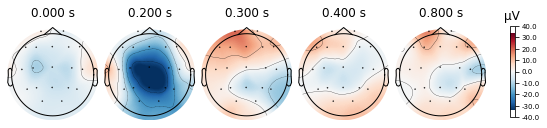

In [62]:
evoked_T0.plot_joint()
evoked_T0.plot_topomap(times=[0.0, 0.2, 0.3, 0.4, 0.8]);

No projector specified for this dataset. Please consider the method self.add_proj.


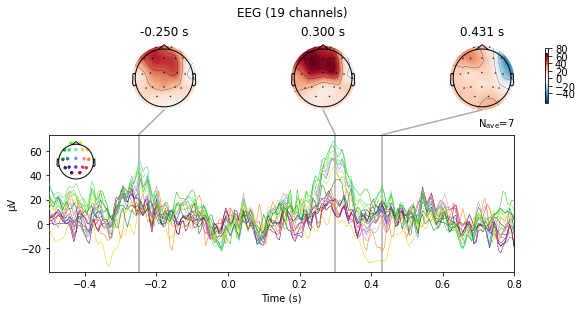

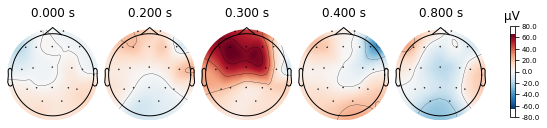

In [63]:
evoked_T1.plot_joint()
evoked_T1.plot_topomap(times=[0.0, 0.2, 0.3, 0.4, 0.8]);

No projector specified for this dataset. Please consider the method self.add_proj.


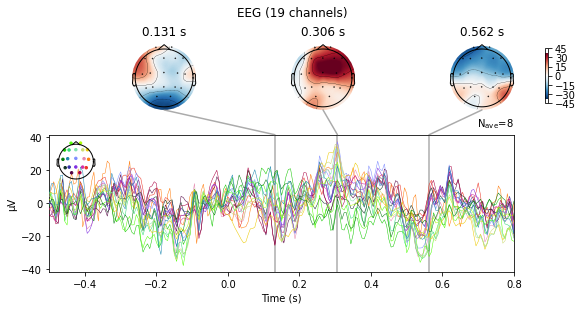

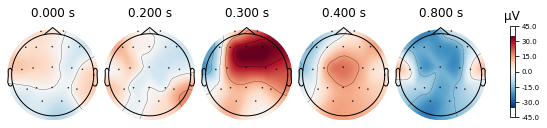

In [64]:
evoked_T2.plot_joint()
evoked_T2.plot_topomap(times=[0.0, 0.2, 0.3, 0.4, 0.8]);

### Computing functional connectivity

In [65]:
conn_T1 = mne_connectivity.spectral_connectivity_epochs(epochs['2'], method='coh')

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=-0.500s..0.800s for estimation (209 points)
    frequencies: 4.6Hz..79.6Hz (99 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    assembling connectivity matrix
[Connectivity computation done]


In [66]:
def plot_topomap_connectivity_2d(info, con, picks=None, pairs=None, vmin=None, vmax=None, cm=None, show_values=False, show_names=True):
    """
    Plots connectivity-like data in 2d

    Drawing every pair of channels will likely make a mess
    There are two options to avoid it:
    - provide picks
    - provide specific pairs of channels to draw
    """

    # get positions
    _, pos, _, _, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');

#     if picks is None and pairs is None:
#         picks = info.ch_names

    ch_names_lower = [ch.lower() for ch in info.ch_names]
    if picks:
        picks_lower = [ch.lower() for ch in picks]
    if pairs:
        pairs_lower = [tuple(sorted([ch1.lower(), ch2.lower()])) for ch1, ch2 in pairs]

    rows = []
    for idx1, ch1 in enumerate(ch_names_lower):
        for idx2, ch2 in enumerate(ch_names_lower):
            if ch1 >= ch2:
                continue
            if picks and (ch1 not in picks_lower or ch2 not in picks_lower):
                    continue
            if pairs and (ch1, ch2) not in pairs_lower:
                    continue
            rows.append((
                pos[idx1],
                pos[idx2],
                con[idx1, idx2]
            ))

    if not len(rows):
        raise ValueError('No pairs to plot')

    con_to_plot = np.array([row[2] for row in rows])
    if vmin is None:
        vmin = np.percentile(con_to_plot, 2)
    if vmax is None:
        vmax = np.percentile(con_to_plot, 98)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    if cm is None:
        cm = sns.diverging_palette(240, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=[5, 5])
    mne.viz.utils.plot_sensors(info, show_names=show_names, show=False, axes=ax);
    for row in rows:
        if (row[2] > vmin) and  (row[2] < vmax):
          rgba_color = cm(norm(row[2]))
          plt.plot([row[0][0], row[1][0]], [row[0][1], row[1][1]], color=rgba_color)
          if show_values:
              plt.text((row[0][0] + row[1][0]) / 2,
                      (row[0][1] + row[1][1]) / 2,
                      '{:.2f}'.format(row[2]))

In [67]:
conn_T0 = mne_connectivity.spectral_connectivity_epochs(epochs['1'], method='coh', verbose=False);
conn_T1 = mne_connectivity.spectral_connectivity_epochs(epochs['2'], method='coh', verbose=False);
conn_T2 = mne_connectivity.spectral_connectivity_epochs(epochs['3'], method='coh', verbose=False);

In [68]:
conn_T0.get_data(output="dense").shape

(19, 19, 99)

In [69]:
conn_T0_all = conn_T0.get_data(output="dense")[:, :, 1:50].mean(axis=2)
conn_T0_all = conn_T0_all + conn_T0_all.T

conn_T1_all = conn_T1.get_data(output="dense")[:, :, 1:50].mean(axis=2)
conn_T1_all = conn_T1_all + conn_T1_all.T

conn_T2_all = conn_T2.get_data(output="dense")[:, :, 1:50].mean(axis=2)
conn_T2_all = conn_T2_all + conn_T2_all.T

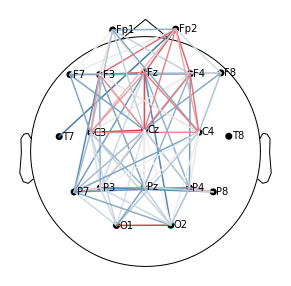

In [70]:
plot_topomap_connectivity_2d(epochs.info, conn_T0_all, picks=epochs.ch_names, vmin=0.5);

In [71]:
# plot connectivity for T1 and T2
# change vmin such way that you see the difference

# YOUR CODE HERE

Over the motor cortex, beta waves (12-20 Hz) are associated with the muscle contractions that happen in isotonic movements and are suppressed prior to and during movement changes, with similar observations across fine and gross motor skills.

In [72]:
# calculate coherence in beta band
# plot 5-10 pairs that you are interested in
# using pairs=[('F7', 'F4'), ('O2', 'T7'), ...] in function plot_topomap_connectivity_2d

# YOUR CODE HERE